In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
import pandas as pd

import numpy.random as npr

from matplotlib.ticker import AutoMinorLocator, MultipleLocator, FuncFormatter
import matplotlib.dates as mdates
from datetime import datetime, date, timedelta
from scipy import optimize
from scipy import stats
from scipy import integrate

#import QuantLib as ql
import copy

npr.seed(12345)

%matplotlib inline

In [2]:
dir       = 'data/'
file_name = 'grid1_zheb51fo.xlsx'

UX1       = pd.read_excel(dir+file_name, sheet_name='UX1_Index')
UX2       = pd.read_excel(dir+file_name, sheet_name='UX2_Index')
UX1       = UX1.set_index('Date')
UX2       = UX2.set_index('Date')

UX1.sort_index(inplace=True)
UX2.sort_index(inplace=True)

UX1

,PX_LAST,PX_VOLUME
Date,,
2010-01-04,24.8500,3138
2010-01-05,24.4500,1936
2010-01-06,23.5500,1958
2010-01-07,23.1500,1760
2010-01-08,22.5500,2050
...,...,...
2022-01-12,20.9713,76675
2022-01-13,22.0944,82700
2022-01-14,21.7462,102849


Historical data of SPX price found at https://www.wsj.com/market-data/quotes/index/SPX/historical-prices

In [3]:
file_name         = 'SPX_HistoricalData.csv'
SPX_price         = pd.read_csv(dir+file_name)
SPX_price['Date'] = pd.to_datetime(SPX_price['Date'],format='%m/%d/%y')
SPX_price         = SPX_price.set_index('Date')
SPX_price.sort_index(inplace=True)
SPX_price

,Open,High,Low,Close
Date,,,,
2010-04-01,1171.23,1181.43,1170.69,1178.10
2010-04-05,1178.71,1187.73,1178.71,1187.44
2010-04-06,1186.01,1191.80,1182.77,1189.44
2010-04-07,1188.23,1189.60,1177.25,1182.45
2010-04-08,1181.75,1188.55,1175.12,1186.44
...,...,...,...,...
2022-01-10,4655.34,4673.02,4582.24,4670.29
2022-01-11,4669.14,4714.13,4638.27,4713.07
2022-01-12,4728.59,4748.83,4706.71,4726.35


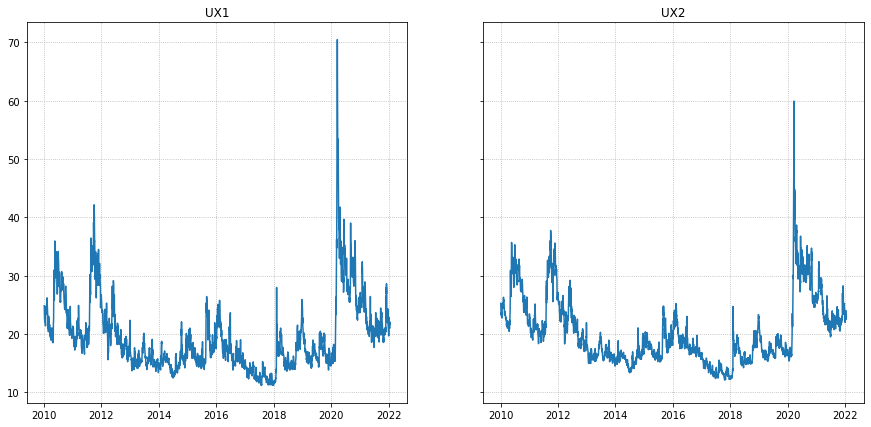

In [4]:
fig,ax = plt.subplots(ncols=2, figsize=(15,7), sharey=True)
ax[0].plot(UX1.index, UX1.PX_LAST)
ax[1].plot(UX2.index, UX2.PX_LAST)
ax[0].set_title('UX1')
ax[1].set_title('UX2')
ax[0].grid(linestyle='dotted')
ax[1].grid(linestyle='dotted')
plt.show()

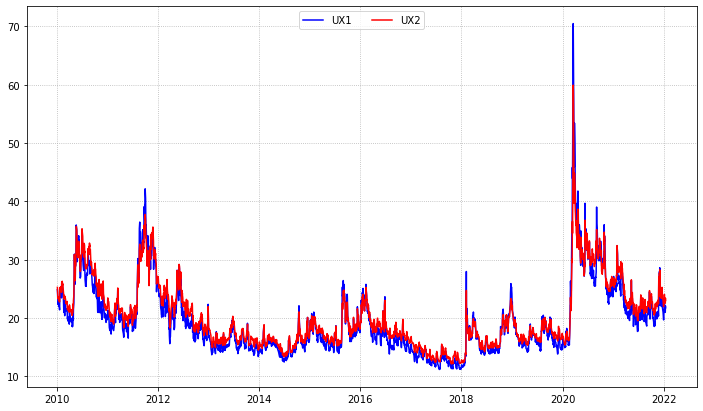

In [5]:
fig,ax = plt.subplots(figsize=(12,7))
ax.plot(UX1.index, UX1.PX_LAST, label='UX1', color='blue')
ax.plot(UX2.index, UX2.PX_LAST, label='UX2', color='red')
ax.legend(loc='upper center', ncol=2)
ax.grid(linestyle='dotted')
plt.show()

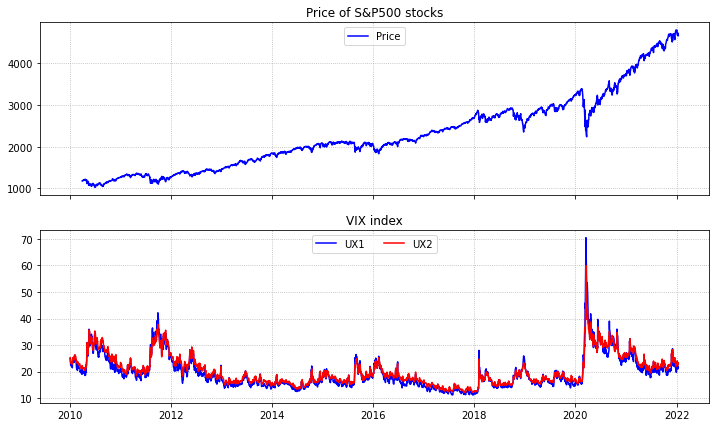

In [6]:
fig,ax = plt.subplots(nrows=2,figsize=(12,7), sharex=True)
ax[0].plot(SPX_price.index, SPX_price.Close, label='Price', color='blue')
ax[0].legend(loc='upper center', ncol=2)
ax[0].grid(linestyle='dotted')
ax[0].set_title('Price of S&P500 stocks')

ax[1].plot(UX1.index, UX1.PX_LAST, label='UX1', color='blue')
ax[1].plot(UX2.index, UX2.PX_LAST, label='UX2', color='red')
ax[1].legend(loc='upper center', ncol=2)
ax[1].grid(linestyle='dotted')
ax[1].set_title('VIX index')
plt.show()

## Heston Model

In [7]:
start     = '2010-04-05'
stop      = '2022-01-14'
mask      = ( UX1.index       >= start ) & ( UX1.index       < stop )
UX1       =   UX1[      mask]
mask      = ( UX2.index       >= start ) & ( UX2.index       < stop )
UX2       =   UX2[      mask]
mask      = ( SPX_price.index >= start ) & ( SPX_price.index < stop )
SPX_price =   SPX_price[mask]

UX1       = UX1.drop(UX1.drop(SPX_price.index).index)
UX1       = UX2.drop(UX2.drop(SPX_price.index).index)

In [8]:
def heston_pde_euler( S_0,   T,     r,     k,  theta,
                      v_0, rho, sigma, steps, Npaths ):
    dt         = T / steps
    size       = ( Npaths, steps )
    prices     = np.zeros(         size )
    volatility = np.zeros(         size )
    S_t        = np.full ( Npaths,  S_0 )
    v_t        = np.full ( Npaths,  v_0 )
    for t in range( steps ):
        WT  = np.sqrt( dt ) * np.random.multivariate_normal( np.array( [0,  0] ), np.array( [[1, rho], [rho, 1]] ), size=Npaths )

        S_t = S_t +              r * S_t                   * dt + S_t   * np.sqrt( v_t ) * WT[:, 0]
        #S_t = S_t * np.exp( (    r - 0.5           * v_t ) * dt +         np.sqrt( v_t ) * WT[:, 0] )
        v_t =       np.abs(    v_t +   k * ( theta - v_t ) * dt + sigma * np.sqrt( v_t ) * WT[:, 1] )

        prices[    :,t] = S_t
        volatility[:,t] = v_t

    return prices, volatility

In [44]:
def heston_pde_milstein(S_0,   T,     r,     k,  theta,
                        v_0, rho, sigma, steps, Npaths):
    dt         = T / steps
    size       = ( Npaths, steps )
    prices     = np.zeros(         size )
    volatility = np.zeros(         size )
    S_t        = np.full ( Npaths,  S_0 )
    v_t        = np.full ( Npaths,  v_0 )
    for t in range( steps ):
        WT  = np.sqrt( dt ) * np.random.multivariate_normal( np.array( [0,  0] ), np.array( [[1, rho], [rho, 1]] ), size=Npaths )

        S_t = S_t +              r * S_t                   * dt + S_t   * np.sqrt( v_t ) * WT[:, 0] + .25 *   S_t**2 * ( WT[:,0]**2 - dt )
        #S_t = S_t * np.exp( (    r - 0.5           * v_t ) * dt +         np.sqrt( v_t ) * WT[:, 0] )
        v_t =       np.abs(    v_t +   k * ( theta - v_t ) * dt + sigma * np.sqrt( v_t ) * WT[:, 1] + .25 * sigma**2 * ( WT[:,1]**2 - dt ) )

        prices[    :, t] = S_t
        volatility[:, t] = v_t

    return prices, volatility

In [45]:
def r_comp(S, v, dt, N, rho):
    r  = np.empty( ( N, S.size ) )

    WT = np.random.multivariate_normal( np.array( [0,  0] ), np.array( [[1, rho], [rho,1]] ), size=N )
    for t in range( 1, S.size ):
        #r[:, t]  = v[t-1] / 2 + np.log( S[t] / S[t-1] ) / dt - np.sqrt( v[t-1] / dt ) * WT[:, 0]
        #r[:, t]  = ( S[t] / S[t-1] - np.sqrt( v[t-1] )          * WT[:, 0]  - 1 ) / dt
        r[:, t]  = ( S[t] / S[t-1] - 1 ) / dt - np.sqrt( v[t] / dt ) * WT[:, 0] - S[t-1] * ( WT[:, 0]**2 - 1 ) / 4
        
    return r.mean( axis=0 )

In [46]:
T       = 1
steps   = 1
Npaths  = 100
delta   = T / steps

rho     = -.7890 # don't know how to find it
#rt      = 100000   # don't know how to find it
r       = r_comp(SPX_price.Close.values, UX1.PX_LAST.values**2, delta, 1000, rho)
n       = 20

prices1 = np.empty( ( SPX_price.index.size - n, Npaths ) )
prices2 = np.empty( ( SPX_price.index.size - n, Npaths ) )
vol1    = np.empty( (       UX1.index.size - n, Npaths ) )
vol2    = np.empty( (       UX2.index.size - n, Npaths ) )

for i in range(n,UX1.index.size):
    Vt1             = UX1.PX_LAST.iloc[    i-n:i].values**2
    Vt2             = UX2.PX_LAST.iloc[    i-n:i].values**2
    S               = SPX_price.Close.iloc[i-n:i].values
    rt              = r[i]

    S0              = S[  -1]
    V10             = Vt1[-1]
    V20             = Vt2[-1]

    P1              = ( ( 1 / n    * sum( ( Vt1[i] * Vt1[i-1])**.5 for i in range( 1, n ) )   -
                          1 / n**2 * sum( ( Vt1[i] / Vt1[i-1])**.5 for i in range( 1, n ) )   *
                                     sum(            Vt1[i-1]      for i in range( 1, n ) ) ) /
                      ( delta / 2 - delta / ( 2 * n**2 )                                      *
                                     sum(            Vt1[i-1]      for i in range( 1, n ) ) ) )
    P2              = ( ( 1 / n    * sum( ( Vt2[i] * Vt2[i-1])**.5 for i in range( 1, n ) )   -
                          1 / n**2 * sum( ( Vt2[i] / Vt2[i-1])**.5 for i in range( 1, n ) )   *
                                     sum(            Vt2[i-1]      for i in range( 1, n ) ) ) /
                      ( delta / 2 - delta / ( 2 * n**2 )                                      *
                                     sum(            Vt2[i-1]      for i in range( 1, n ) ) ) )

    k1              = 2 / delta * (1 + P1 * delta / ( 2 * n ) * sum(        1 / Vt1[i-1]        for i in range( 1, n ) ) -
                                   1 / n  *                     sum( ( Vt1[i] / Vt1[i-1] )**0.5 for i in range( 1, n ) ) )
    k2              = 2 / delta * (1 + P2 * delta / ( 2 * n ) * sum(        1 / Vt2[i-1]        for i in range( 1, n ) ) -
                                   1 / n  *                     sum( ( Vt2[i] / Vt2[i-1] )**0.5 for i in range( 1, n ) ) )

    sigma1          = ( 4 / ( delta * n ) * sum( Vt1[i]**.5 - Vt1[i-1]**.5 - delta /
                      ( 2 * Vt1[i-1]**.5 ) *( P1 - k1 * Vt1[i-1] ) for i in range( 1, n ) ) )**.5
    sigma2          = ( 4 / ( delta * n ) * sum( Vt2[i]**.5 - Vt2[i-1]**.5 - delta /
                      ( 2 * Vt2[i-1]**.5 ) *( P2 - k2 * Vt2[i-1] ) for i in range( 1, n ) ) )**.5

    theta1          = ( P1 + sigma1**2 / 2 ) / k1
    theta2          = ( P2 + sigma2**2 / 2 ) / k2

    #p1, v1          = heston_pde_euler( S0, T, rt, k1, theta1, V10, rho, sigma1, steps, Npaths )
    #p2, v2          = heston_pde_euler( S0, T, rt, k2, theta2, V20, rho, sigma2, steps, Npaths )
    p1, v1          = heston_pde_milstein( S0, T, rt, k1, theta1, V10, rho, sigma1, steps, Npaths )
    p2, v2          = heston_pde_milstein( S0, T, rt, k2, theta2, V20, rho, sigma2, steps, Npaths )



    vol1[   i-n,:] = v1[:].ravel( )
    vol2[   i-n,:] = v2[:].ravel( )
    prices1[i-n,:] = p1[:].ravel( )
    prices2[i-n,:] = p2[:].ravel( )

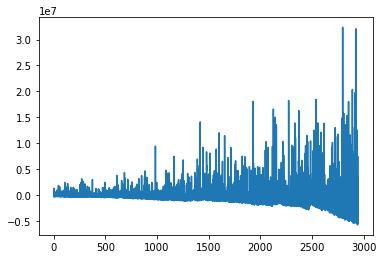

In [47]:
plt.plot(prices1[:,0])

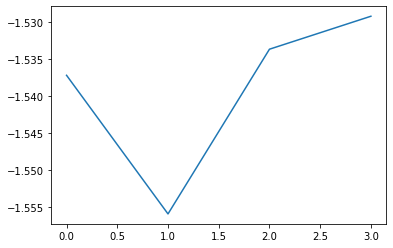

In [51]:
plt.plot(r[1:5])

In [14]:
vol1    = np.insert( vol1,    0, np.full( ( n, Npaths ), np.nan ), axis=0 )
vol2    = np.insert( vol2,    0, np.full( ( n, Npaths ), np.nan ), axis=0 )
prices1 = np.insert( prices1, 0, np.full( ( n, Npaths ), np.nan ), axis=0 )
prices2 = np.insert( prices2, 0, np.full( ( n, Npaths ), np.nan ), axis=0 )

for k in range(Npaths):
    col      = 'sim_' + str( k )
    UX1[col] = pd.Series( np.sqrt( vol1[:,k] ), index = UX1.index)
    UX2[col] = pd.Series( np.sqrt( vol2[:,k] ), index = UX2.index)

UX1['mean_sim'] = ( UX1.loc[:, ['sim_' + str( k ) for k in range( Npaths ) ] ] ).mean( axis=1 )
UX2['mean_sim'] = ( UX2.loc[:, ['sim_' + str( k ) for k in range( Npaths ) ] ] ).mean( axis=1 )

/tmp/ipykernel_21474/1179537975.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  UX1[col] = pd.Series( np.sqrt( vol1[:,k] ), index = UX1.index)
/tmp/ipykernel_21474/1179537975.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  UX2[col] = pd.Series( np.sqrt( vol2[:,k] ), index = UX2.index)


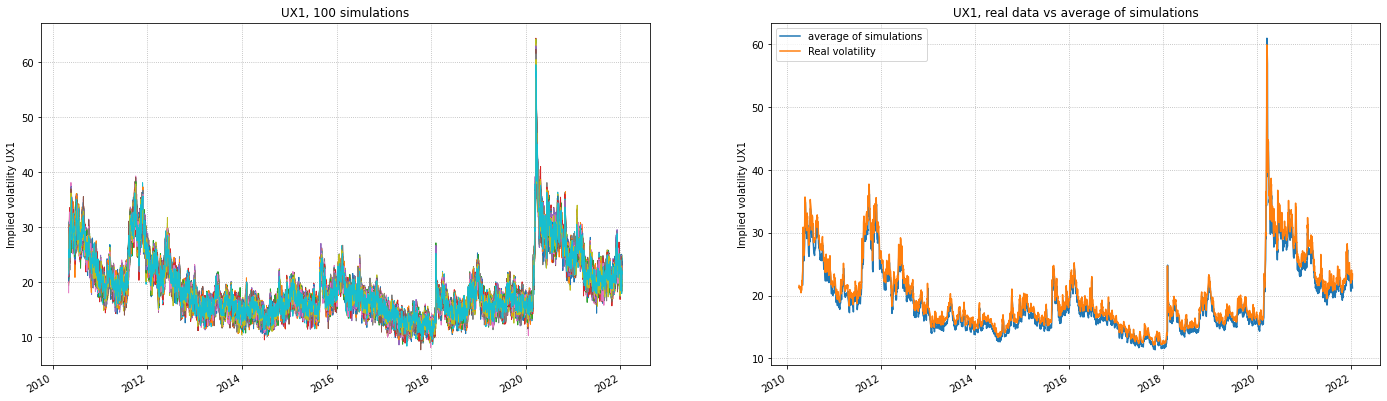

In [15]:
fig, ax = plt.subplots( ncols=2, figsize=( 24, 7 ) )

#ax[0].plot(UX1.index, UX1.PX_LAST, lw=2, label='Real volatility')
for k in range( Npaths ):
    col = 'sim_' + str(k)
    ax[0].plot( UX1.index, UX1[col], label='', lw=1 )
ax[0].grid( linestyle='dotted' )
#ax[0].legend(loc='upper left')
ax[0].set_title ( 'UX1, ' + str( Npaths ) + ' simulations' )
ax[0].set_ylabel( 'Implied volatility UX1' )

ax[1].plot( UX1.index, UX1['mean_sim'], label='average of simulations' )
ax[1].plot( UX1.index, UX1.PX_LAST, label='Real volatility')
ax[1].grid( linestyle='dotted')
ax[1].legend( loc='upper left')
ax[1].set_title ( 'UX1, real data vs average of simulations')
ax[1].set_ylabel( 'Implied volatility UX1')

fig.autofmt_xdate( )
plt.show()

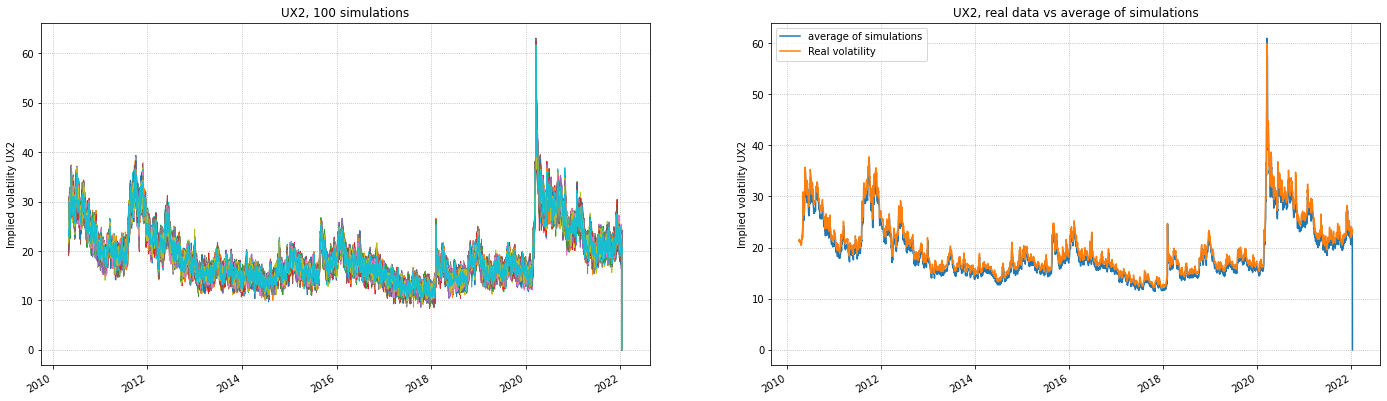

In [16]:
fig, ax = plt.subplots(ncols=2, figsize=(24,7))

for k in range(Npaths):
    col = 'sim_' + str(k)
    ax[0].plot(UX2.index, UX2[col], label='', lw=1)
#ax[0].plot(UX2.index, UX2.PX_LAST, lw=5, label='Real volatility')
ax[0].grid(linestyle='dotted')
#ax[0].legend(loc='best')
ax[0].set_title('UX2, ' + str(Npaths) + ' simulations')
ax[0].set_ylabel('Implied volatility UX2')

ax[1].plot(UX2.index, UX2['mean_sim'], label='average of simulations')
ax[1].plot(UX2.index, UX2.PX_LAST, label='Real volatility')
ax[1].grid(linestyle='dotted')
ax[1].legend(loc='best')
ax[1].set_title('UX2, real data vs average of simulations')
ax[1].set_ylabel('Implied volatility UX2')

fig.autofmt_xdate()
plt.show()

In [17]:
UX1['resid'] = UX1['mean_sim'] - UX1['PX_LAST']
UX2['resid'] = UX2['mean_sim'] - UX2['PX_LAST']

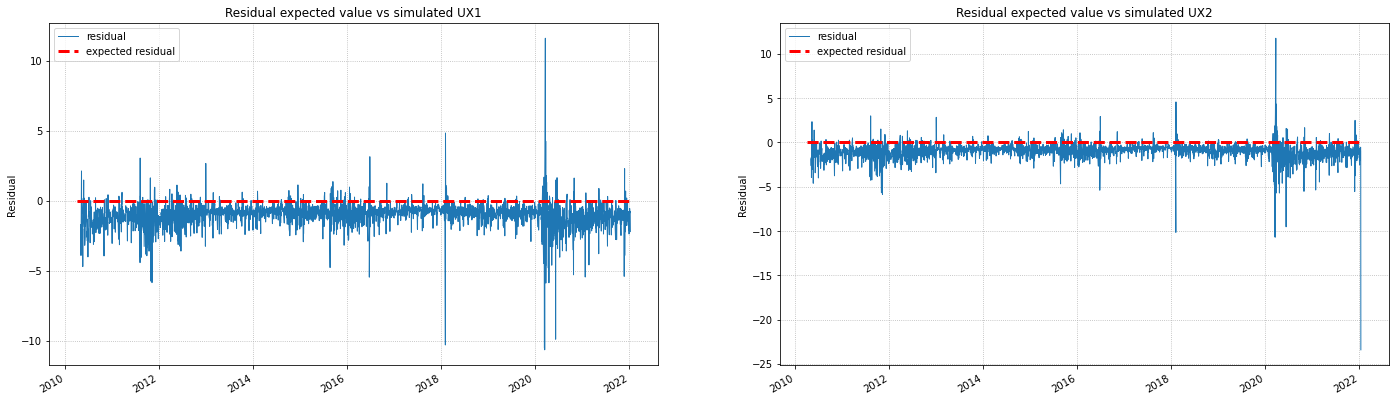

In [18]:
fig, ax = plt.subplots(ncols=2, figsize=(24,7))

ax[0].plot(UX1.index, UX1.resid, lw=1, label='residual')
ax[0].hlines(0, UX1.index.min(), UX1.index.max(), lw=3, color='red', linestyle='dashed', label='expected residual')
ax[0].grid(linestyle='dotted')
ax[0].legend(loc='best')
ax[0].set_title('Residual expected value vs simulated UX1')
ax[0].set_ylabel('Residual')

ax[1].plot(UX2.index, UX2.resid, lw=1, label='residual')
ax[1].hlines(0, UX2.index.min(), UX2.index.max(), lw=3, color='red', linestyle='dashed', label='expected residual')
ax[1].grid(linestyle='dotted')
ax[1].legend(loc='best')
ax[1].set_title('Residual expected value vs simulated UX2')
ax[1].set_ylabel('Residual')

fig.autofmt_xdate()
plt.show()

N  			=		 228.14165275914368 		+/-		 3.389169640313699
mu 			=		 -0.8407601900474533 		+/-		 0.007864832892270033
std			=		 0.4584832402027004 		+/-		 0.007864832896623727


R2 			=		 0.9658227649839505 
R 			=		 0.982762822345224

Covariance matrix:
 [[ 1.         -0.07277659]
 [-0.07277659  1.        ]]

n degrees of freedom 	=		 80

chi2 			=		 1887.6322124612966
p-value 		=		 0.0


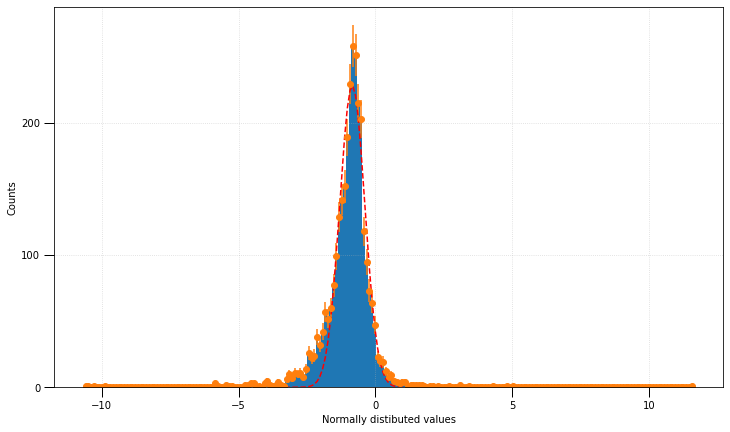

In [40]:
b                 = np.histogram_bin_edges(UX1.resid.dropna(), bins='fd')
fig, ax           = plt.subplots(figsize=(12, 7))
entries, edges, _ = ax.hist(UX1.resid, bins=b)
ax.set_ylabel('Counts')
ax.set_xlabel("Normally distibuted values")
ax.yaxis.set_major_locator(MultipleLocator(100))
ax.tick_params(which='major', width=1.0)
ax.tick_params(which='major', length=10)
ax.grid(linestyle='dotted', alpha=0.5)

# calculate bin centers
bin_centers = 0.5 * (edges[:-1] + edges[1:])

# draw errobars, use the sqrt error. You can use what you want there
# poissonian 1 sigma intervals would make more sense
ax.errorbar(bin_centers, entries, yerr=np.sqrt(entries), fmt='o')

def gaussian(x, N, mu, sig):
    return N * np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

popt, pcov = optimize.curve_fit(gaussian, bin_centers, entries, p0 = [100,0, 1])
ax.plot(bin_centers, gaussian(bin_centers, popt[0],popt[1],popt[2]), linestyle='dashed',c = 'r' )

ssr = np.sum((entries - gaussian(bin_centers, popt[0],popt[1],popt[2]))**2)
tss = np.sum((np.mean(entries) - entries)**2)

rsq = 1 - ssr / tss
sigma_y  = np.sqrt(np.abs(entries))
mask_err = (sigma_y!=0)

print("N  \t\t\t=\t\t", popt[0], "\t\t+/-\t\t", pcov[0,0]**.5)
print("mu \t\t\t=\t\t", popt[1], "\t\t+/-\t\t", pcov[1,1]**.5)
print("std\t\t\t=\t\t", popt[2], "\t\t+/-\t\t", pcov[2,2]**.5)

print("\n")
print("R2 \t\t\t=\t\t", rsq, "\nR \t\t\t=\t\t", np.sqrt(rsq))
print("\nCovariance matrix:\n", np.corrcoef(bin_centers,entries)) # check with the correlation matrix that R is the correlation coefficient

ndof = len(bin_centers[mask_err]) - 3
print("\nn degrees of freedom \t=\t\t", ndof)
# calculate the chi^2
chi2 = np.sum(((entries[mask_err] - (gaussian(bin_centers[mask_err], popt[0],popt[1],popt[2])))**2) / sigma_y[mask_err])
print("\nchi2 \t\t\t=\t\t", chi2)
# calculate the p-value from the chi^2, the n.d.o.f., and the comulative chi^2 distribution
pvalue = 1. - stats.chi2.cdf(chi2, ndof)
print("p-value \t\t=\t\t", pvalue) # if the p-value is < 0.05, the fit is considered unsatisfactory

N  			=		 234.58224988643386 		+/-		 3.014478482278065
mu 			=		 -0.8327010059831429 		+/-		 0.007046011273183507
std			=		 0.47483493405565647 		+/-		 0.007046011312800421


R2 			=		 0.9629958370282311 
R 			=		 0.9813235129294676

Covariance matrix:
 [[1.         0.11835868]
 [0.11835868 1.        ]]

n degrees of freedom 	=		 77

chi2 			=		 2033.0491755973057
p-value 		=		 0.0


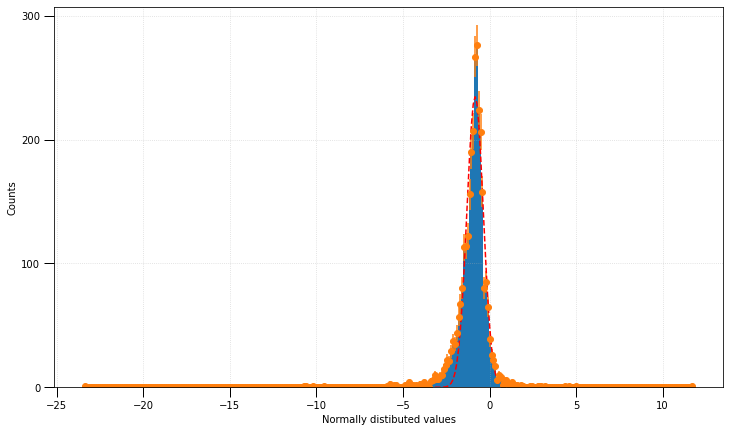

In [41]:
b                 = np.histogram_bin_edges(UX2.resid.dropna(), bins='fd')
fig, ax           = plt.subplots(figsize=(12, 7))
entries, edges, _ = ax.hist(UX2.resid, bins=b)
ax.set_ylabel('Counts')
ax.set_xlabel("Normally distibuted values")
ax.yaxis.set_major_locator(MultipleLocator(100))
ax.tick_params(which='major', width=1.0)
ax.tick_params(which='major', length=10)
ax.grid(linestyle='dotted', alpha=0.5)

# calculate bin centers
bin_centers = 0.5 * (edges[:-1] + edges[1:])

# draw errobars, use the sqrt error. You can use what you want there
# poissonian 1 sigma intervals would make more sense
ax.errorbar(bin_centers, entries, yerr=np.sqrt(entries), fmt='o')

def gaussian(x, N, mu, sig):
    return N * np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

popt, pcov = optimize.curve_fit(gaussian, bin_centers, entries, p0 = [100,0, 1])
ax.plot(bin_centers, gaussian(bin_centers, popt[0],popt[1],popt[2]), linestyle='dashed',c = 'r' )

ssr = np.sum((entries - gaussian(bin_centers, popt[0],popt[1],popt[2]))**2)
tss = np.sum((np.mean(entries) - entries)**2)

rsq = 1 - ssr / tss
sigma_y  = np.sqrt(np.abs(entries))
mask_err = (sigma_y!=0)

print("N  \t\t\t=\t\t", popt[0], "\t\t+/-\t\t", pcov[0,0]**.5)
print("mu \t\t\t=\t\t", popt[1], "\t\t+/-\t\t", pcov[1,1]**.5)
print("std\t\t\t=\t\t", popt[2], "\t\t+/-\t\t", pcov[2,2]**.5)

print("\n")
print("R2 \t\t\t=\t\t", rsq, "\nR \t\t\t=\t\t", np.sqrt(rsq))
print("\nCovariance matrix:\n", np.corrcoef(bin_centers,entries)) # check with the correlation matrix that R is the correlation coefficient

ndof = len(bin_centers[mask_err]) - 3
print("\nn degrees of freedom \t=\t\t", ndof)
# calculate the chi^2
chi2 = np.sum(((entries[mask_err] - (gaussian(bin_centers[mask_err], popt[0],popt[1],popt[2])))**2) / sigma_y[mask_err])
print("\nchi2 \t\t\t=\t\t", chi2)
# calculate the p-value from the chi^2, the n.d.o.f., and the comulative chi^2 distribution
pvalue = 1. - stats.chi2.cdf(chi2, ndof)
print("p-value \t\t=\t\t", pvalue) # if the p-value is < 0.05, the fit is considered unsatisfactory

Sistematic underestimation of volatility

Problems on prices (i get values without any sense)

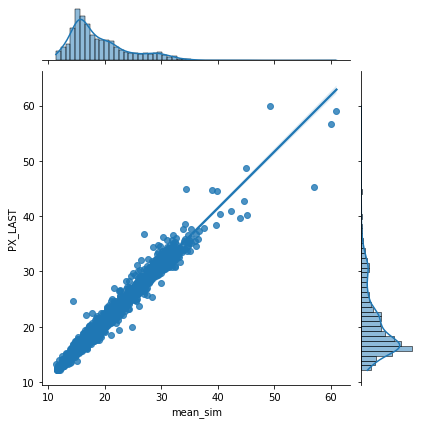

In [21]:
sns.jointplot(x='mean_sim', y='PX_LAST', data=UX1, kind='reg')

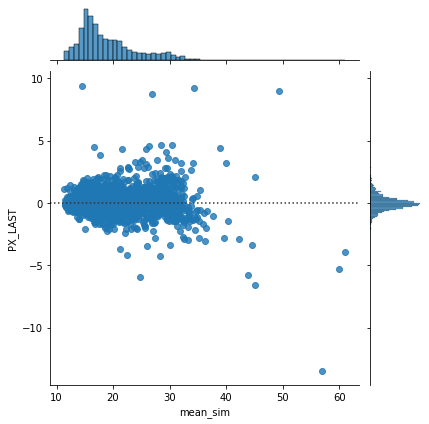

In [30]:
sns.jointplot(x='mean_sim', y='PX_LAST', data=UX1, kind='resid')

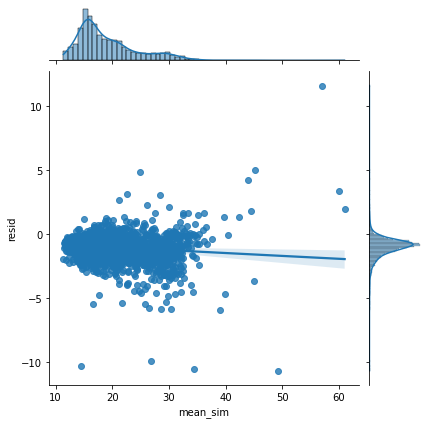

In [23]:
sns.jointplot(x='mean_sim', y='resid', data=UX1, kind='reg')

In [24]:
# characteristic function
def f( phi, kappa, theta, sigma,    rho,
        v0,     r,     T,    s0, status ):

    a = kappa * theta
    x = np.log( s0 )

    # remind that lamda is zero
    if status == 1:
        u = 0.5
        b = kappa - rho * sigma
    else:
        u = -.5
        b = kappa

    d = np.sqrt( (   rho * sigma * phi * 1j - b )**2 - sigma**2 * ( 2 * u * phi * 1j - phi**2 ) )
    g =        ( b - rho * sigma * phi * 1j + d)     / (b - rho   * sigma * phi * 1j -      d   )

    C = ( r * phi * 1j * T + ( a / sigma**2 ) * ( ( b - rho * sigma * phi * 1j + d ) *
          T - 2 * np.log( ( 1 - g * np.exp( d * T ) ) / ( 1 - g ) ) ) )
    D = ( b - rho * sigma * phi * 1j + d ) / ( sigma**2 ) * ( ( 1 - np.exp( d * T ) ) / ( 1 - g * np.exp( d * T ) ) )

    return np.exp( C + D * v0 + 1j * phi * x )

# P1 and P2
def p( kappa, theta, sigma, rho, v0, r, T, s0, K, status ):
    integrand = lambda phi: ( np.exp( -1j * phi * np.log( K ) ) *
                              f( phi, kappa, theta, sigma, rho, v0, r, T, s0, status) / (1j * phi)).real

    return ( 0.5 + ( 1 / np.pi ) * integrate.quad( integrand, 0, 100 )[0] ) # approximate indefinite intergral with a definite one

def p1(       kappa, theta, sigma, rho, v0, r, T, s0, K    ):
    return p( kappa, theta, sigma, rho, v0, r, T, s0, K, 1 )

def p2(       kappa, theta, sigma, rho, v0, r, T, s0, K    ):
    return p( kappa, theta, sigma, rho, v0, r, T, s0, K, 2 )

# call price
def call_price( kappa, theta, sigma, rho, v0, r, T, s0, K ):
    P1 = p1( kappa, theta, sigma, rho, v0, r, T, s0, K )
    P2 = p2( kappa, theta, sigma, rho, v0, r, T, s0, K )

    result = ( s0 * P1 - K * np.exp( -r * T ) * P2 )

    if result < 0 or k - s0 > 1: # negative result or initial price very very low with respect to k
        result = 0

    return result

In [25]:
T       = 1
steps   = 1
Npaths  = 100
delta   = T / steps

rho     = -.7890 # don't know how to find it
#r       = 2.17   # don't know how to find it
r       = r_comp(SPX_price.Close.values, UX1.PX_LAST.values**2, delta, 1000, rho)
n       = 30

call_prices = np.empty( ( UX1.index.size - n, Npaths ) )

for i in range(n,UX1.index.size):
    Vt1             = UX1.PX_LAST.iloc[    i-n:i].values**2
    Vt2             = UX2.PX_LAST.iloc[    i-n:i].values**2
    S               = SPX_price.Close.iloc[i-n:i].values
    rt              = r[i]

    S0              = S[  -1]
    V10             = Vt1[-1]
    V20             = Vt2[-1]

    P_1             = ( ( 1 / n    * sum( ( Vt1[i] * Vt1[i-1])**.5 for i in range( 1, n ) )   -
                          1 / n**2 * sum( ( Vt1[i] / Vt1[i-1])**.5 for i in range( 1, n ) )   *
                                     sum(            Vt1[i-1]      for i in range( 1, n ) ) ) /
                      ( delta / 2 - delta / ( 2 * n**2 )                                      *
                                     sum(            Vt1[i-1]      for i in range( 1, n ) ) ) )
    P_2             = ( ( 1 / n    * sum( ( Vt2[i] * Vt2[i-1])**.5 for i in range( 1, n ) )   -
                          1 / n**2 * sum( ( Vt2[i] / Vt2[i-1])**.5 for i in range( 1, n ) )   *
                                     sum(            Vt2[i-1]      for i in range( 1, n ) ) ) /
                      ( delta / 2 - delta / ( 2 * n**2 )                                      *
                                     sum(            Vt2[i-1]      for i in range( 1, n ) ) ) )

    k1              = 2 / delta * (1 + P_1 * delta / ( 2 * n ) * sum(        1 / Vt1[i-1]        for i in range( 1, n ) ) -
                                   1 / n   *                     sum( ( Vt1[i] / Vt1[i-1] )**0.5 for i in range( 1, n ) ) )
    k2              = 2 / delta * (1 + P_2 * delta / ( 2 * n ) * sum(        1 / Vt2[i-1]        for i in range( 1, n ) ) -
                                   1 / n   *                     sum( ( Vt2[i] / Vt2[i-1] )**0.5 for i in range( 1, n ) ) )

    sigma1          = ( 4 / ( delta * n ) * sum( Vt1[i]**.5 - Vt1[i-1]**.5 - delta /
                      ( 2 * Vt1[i-1]**.5 ) *( P_1 - k1 * Vt1[i-1] ) for i in range( 1, n ) ) )**.5
    sigma2          = ( 4 / ( delta * n ) * sum( Vt2[i]**.5 - Vt2[i-1]**.5 - delta /
                      ( 2 * Vt2[i-1]**.5 ) *( P_2 - k2 * Vt2[i-1] ) for i in range( 1, n ) ) )**.5

    theta1          = ( P_1 + sigma1**2 / 2 ) / k1
    theta2          = ( P_2 + sigma2**2 / 2 ) / k2

    P_1              = call_price( k1, theta1, sigma1, rho, V10, rt, T, S0, 100 )
    #P_1, v1          = heston_pde_milstein( S0, T, rt, k1, theta1, V10, rho, sigma1, steps, Npaths )
    #P_2, v2          = heston_pde_milstein( S0, T, rt, k2, theta2, V20, rho, sigma2, steps, Npaths )


    call_prices[i-n,:] = P_1.ravel( )

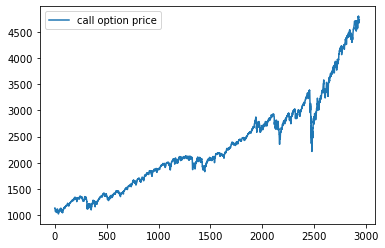

In [26]:
plt.plot(call_prices[:,2], label='call option price')
#plt.plot(SPX_price.Close.values, label='prices real values')
plt.legend()

In [27]:
call_prices = np.insert( call_prices, 0, np.full( ( n, Npaths ), np.nan ), axis=0 )

for k in range(Npaths):
    col      = 'call_sim_' + str( k )
    UX1[col] = pd.Series( call_prices[:,k], index = UX1.index)

UX1['mean_call'] = ( UX1.loc[:, ['call_sim_' + str( k ) for k in range( Npaths ) ] ] ).mean( axis=1 )

/tmp/ipykernel_21474/3350147036.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  UX1[col] = pd.Series( call_prices[:,k], index = UX1.index)


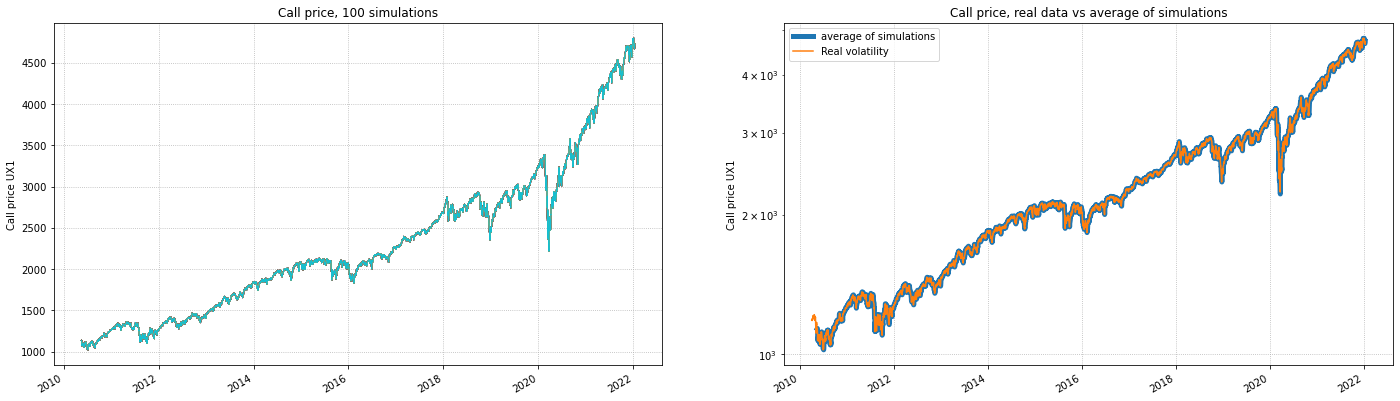

In [28]:
fig, ax = plt.subplots(ncols=2, figsize=(24,7))

for k in range(Npaths):
    col = 'call_sim_' + str(k)
    ax[0].plot(UX1.index, UX1[col], label='', lw=1)
#ax[0].plot(UX2.index, UX2.PX_LAST, lw=5, label='Real volatility')
ax[0].grid(linestyle='dotted')
#ax[0].legend(loc='best')
ax[0].set_title('Call price, ' + str(Npaths) + ' simulations')
ax[0].set_ylabel('Call price UX1')

ax[1].plot(UX1.index, UX1['mean_call'], label='average of simulations', lw=5)
ax[1].plot(UX1.index, SPX_price.Close, label='Real volatility')
ax[1].grid(linestyle='dotted')
ax[1].legend(loc='best')
ax[1].set_title('Call price, real data vs average of simulations')
ax[1].set_ylabel('Call price UX1')
ax[1].set_yscale('log')

fig.autofmt_xdate()
plt.show()

<AxesSubplot:xlabel='Date'>

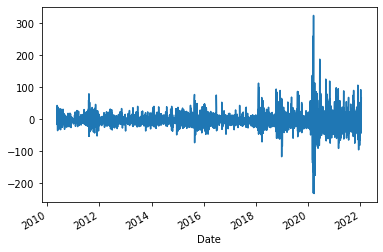

In [29]:
a = UX1['mean_call'] - SPX_price.Close
a.plot()